In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns

import scanorama
import scgen

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


# Load data

In [2]:
d1 = ad.read_h5ad("data/dataseta0_processed.h5ad")
d2 = ad.read_h5ad("data/datasetb0_processed.h5ad")
d2.obs["milestones"] = d2.obs.milestones.cat.rename_categories({'sC': 'sC_batch'})

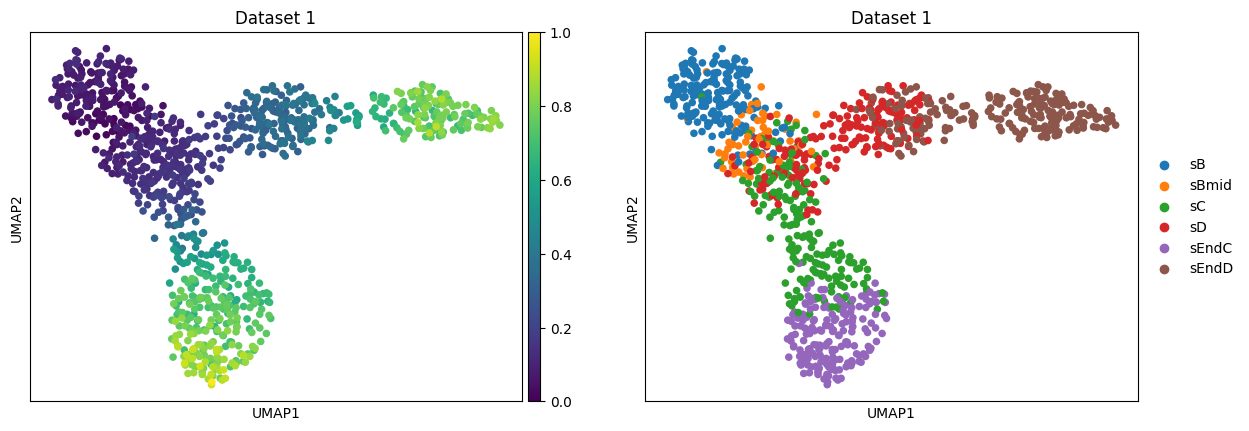

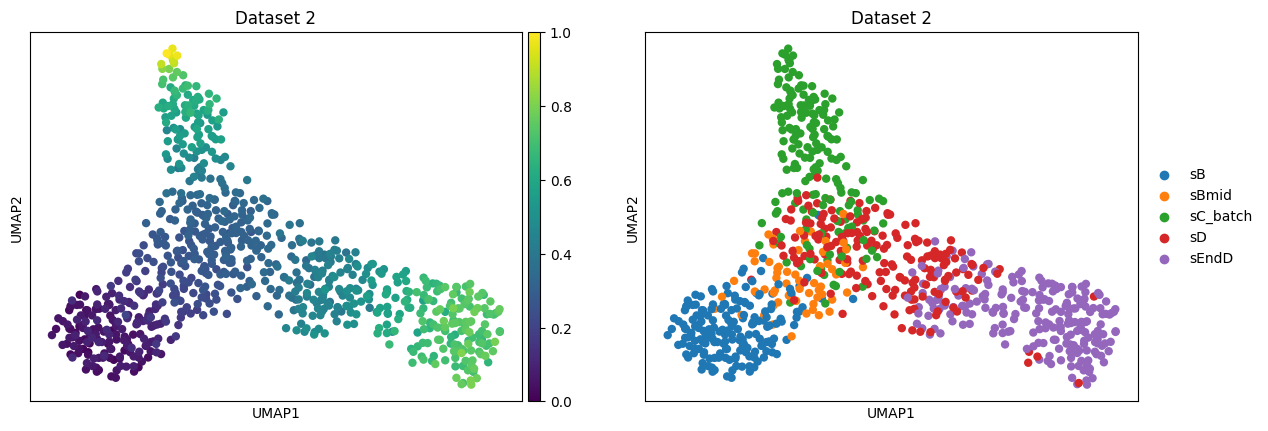

In [4]:
sc.pl.umap(d1, color = [ "dpt_pseudotime", "milestones" ], title=["Dataset 1", "Dataset 1"])
sc.pl.umap(d2, color = [ "dpt_pseudotime", "milestones" ], title=["Dataset 2", "Dataset 2"])

# Experiments

Here we use the top-performing trajectory conservation methods as shown in https://doi.org/10.1038/s41592-021-01336-8, scanorama, scGen and fastMNN

## Scanorama

In [5]:
adatas_cor = scanorama.correct_scanpy(
    [d1, d2],
    return_dimred = True,
)

Found 531 genes among all datasets
[[0.         0.97445255]
 [0.         0.        ]]
Processing datasets (0, 1)


In [6]:
adata_scanorama = sc.concat(
    {"control": adatas_cor[0], "premature stop": adatas_cor[1]},
    label="batch",
    uns_merge="unique",
    index_unique="-",
)


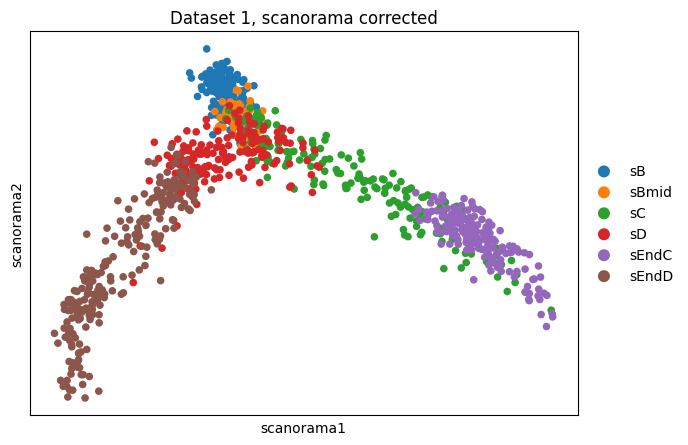

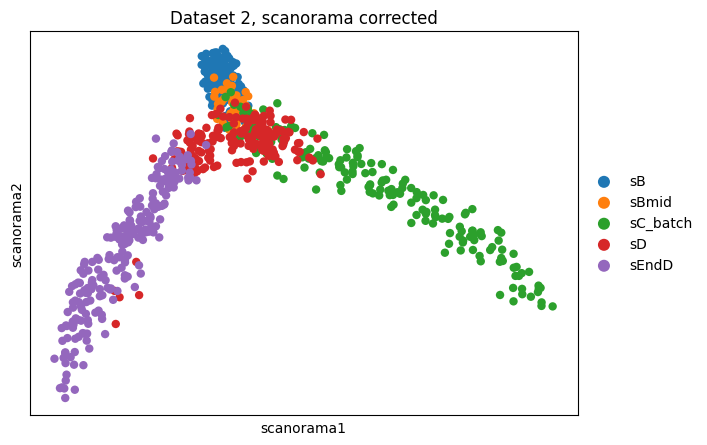

In [7]:
sc.pl.scatter(adatas_cor[0], basis="scanorama", color="milestones", title="Dataset 1, scanorama corrected")
sc.pl.scatter(adatas_cor[1], basis="scanorama", color="milestones", title="Dataset 2, scanorama corrected")

<Axes: xlabel='x', ylabel='y'>

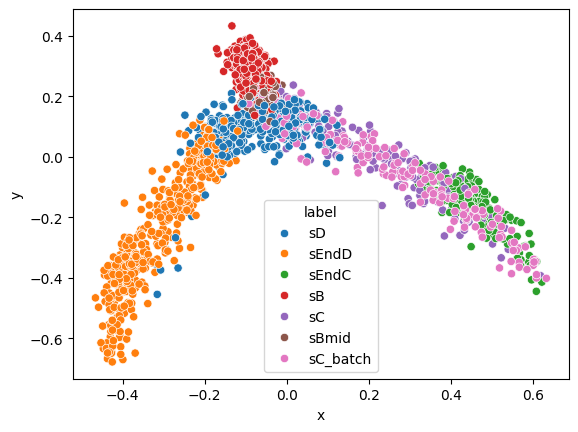

In [8]:
xvals = np.concat((adatas_cor[0].obsm["X_scanorama"][:, 0] ,adatas_cor[1].obsm["X_scanorama"][:, 0]))
yvals = np.concat((adatas_cor[0].obsm["X_scanorama"][:, 1] ,adatas_cor[1].obsm["X_scanorama"][:, 1]))
cats = np.concat((adatas_cor[0].obs["milestones"].values ,adatas_cor[1].obs["milestones"].values))

# create a DataFrame for the legend
legend_df = pd.DataFrame({
    "x": xvals,
    "y": yvals,
    "label": cats,
})

sns.scatterplot(
    data=legend_df,
    x="x",
    y="y",
    hue="label",
    legend=True,
)


## scgen

In [9]:
datasets_mapping = {
    "control": d1,
    "premature stop": d2
}
datasets = ad.concat(datasets_mapping, label="batch")
datasets.obs_names_make_unique()

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [10]:
scgen.SCGEN.setup_anndata(datasets, batch_key="batch", labels_key="milestones")
model = scgen.SCGEN(datasets)

In [11]:
model.train(
    max_epochs=100,
    batch_size=16,
    early_stopping=True,
    early_stopping_patience=25,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.
/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 25 records. Best score: 728.964. Signaling Trainer to stop.


In [12]:
corrected_adata = model.batch_removal()

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:602: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/home/louise/Work/scgen/scgen/_scgen.py:265: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  batch_list[study].X = delta + batch_list[study].X
/home/louise/Work/scgen/scgen/_scgen.py:266: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  temp_cell[batch_ind[study]].X = batch_list[study].X
/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:602: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indice

### Fix scgen

In [13]:
# FIXED IN https://github.com/LouiseDck/scgen or https://github.com/theislab/scgen/pull/104
# 
# import torch
# from torch import Tensor
# from torch.distributions import Distribution, Normal
# from torch.nn.functional import softmax

# from scvi.module._constants import MODULE_KEYS
# from scvi.dataloaders import AnnDataLoader

# dataloader = model._make_data_loader(
#     adata=datasets, indices=None, batch_size=None
# )
# print(len([x for x in dataloader]))
# print(MODULE_KEYS.QZM_KEY)

# zs: list[Tensor] = []
# qz_means: list[Tensor] = []
# qz_vars: list[Tensor] = []  
# for tensors in dataloader:
#     outputs: dict[str, Tensor | Distribution | None] = model.module.inference(
#         **model.module._get_inference_input(tensors)
#     )
#     print(outputs.keys())

#     if "qz" in outputs:
#         qz: Distribution = outputs.get("qz")
#         qzm: Tensor = qz.loc
#         qzv: Tensor = qz.scale.square()
#     else:
#         qzm: Tensor = outputs.get("qzm")
#         qzv: Tensor = outputs.get("qzv")
#         qz: Distribution = Normal(qzm, qzv.sqrt())
# 
#     z: Tensor = outputs.get("z")
#     zs.append(z.cpu())
# 
# latent = torch.cat(zs).detach().numpy()

### Plot data

In [14]:
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)


/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/scanpy/tools/_utils.py:40: UserWarning: You’re trying to run this on 531 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


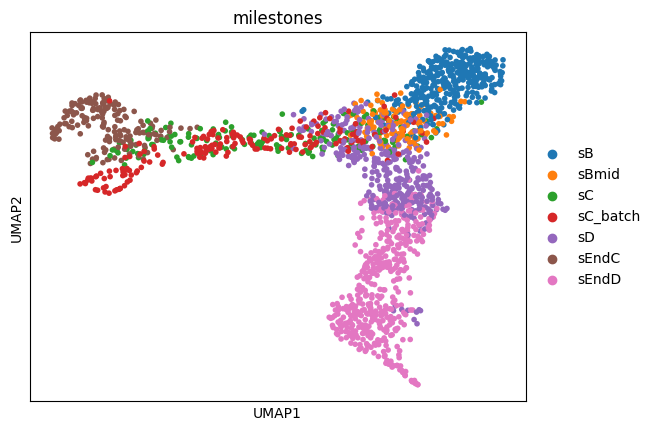

In [15]:
sc.pl.umap(corrected_adata, color='milestones', wspace=0.4)

## fastMNN

The scib paper seems to use an implementation in Python for mnn and not fastMNN. cf: https://github.com/theislab/scib/blob/main/scib/integration.py

In [25]:
import mnnpy

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/mnnpy/utils.py:30: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 1, 'A', False, aligned=True), Array(float32, 1, 'A', False, aligned=True))
  dist[i, j] = np.dot(m[i], n[j])
/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/mnnpy/utils.py:205: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 1, 'C', False, aligned=True), Array(float32, 1, 'A', False, aligned=True))
  scale = np.dot(working, grad)
/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/mnnpy/utils.py:215: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 1, 'C', False, aligned=True), Array(float32, 1, 'A', False, aligned=True))
  curproj = np.dot(grad, curcell)


In [67]:
mnn1 = ad.AnnData(X=d1.X, obs=d1.obs, var=d1.var)
mnn2 = ad.AnnData(X=d2.X, obs=d2.obs, var=d2.var)

In [69]:
mnn1

AnnData object with n_obs × n_vars = 1000 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime'
    var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein', 'mean', 'std'

In [70]:
mnn2

AnnData object with n_obs × n_vars = 822 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime'
    var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein', 'mean', 'std'

In [72]:
corrected_adata, pairinginfo, angles = mnnpy.mnn_correct(
    mnn1, mnn2,
    batch_key="mnn_batch",
    do_concatenate=False
)

Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 1: processing batch 1
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...
Done.


In [73]:
corrected_adata

(AnnData object with n_obs × n_vars = 1000 × 531
     obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime'
     var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein', 'mean', 'std',
 AnnData object with n_obs × n_vars = 822 × 531
     obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime'
     var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein', 'mean', 'std')

In [74]:
adatas_corrected = ad.concat(
    {"control": corrected_adata[0], "premature stop": corrected_adata[1]},
    label="batch",
    uns_merge="unique",
    index_unique="-",
)

In [75]:
adatas_corrected

AnnData object with n_obs × n_vars = 1822 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'batch'

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/scanpy/tools/_utils.py:40: UserWarning: You’re trying to run this on 531 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


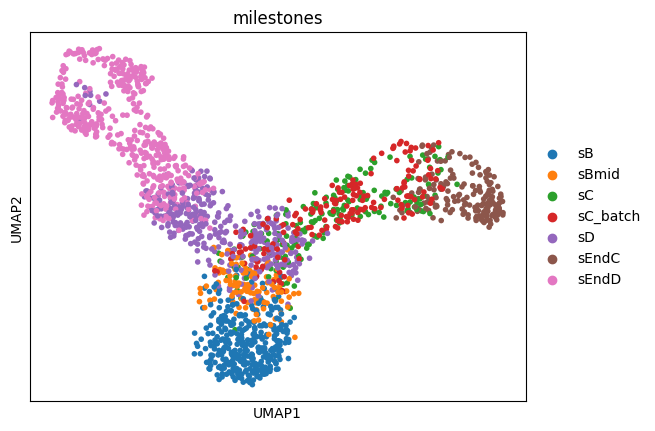

In [77]:
sc.pp.neighbors(adatas_corrected)
sc.tl.umap(adatas_corrected)
sc.pl.umap(adatas_corrected, color='milestones')